In [45]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]= "5" # 학습 환경에 따라 변경

## Import

In [46]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import cv2

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision.models import resnet152
from torchvision import transforms

from tqdm.auto import tqdm
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings(action='ignore') 

In [47]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

## Hyperparameter Setting

In [48]:
CFG = {
    'IMG_HEIGHT_SIZE':150,
    'IMG_WIDTH_SIZE':332,
    'EPOCHS':20,
    'LEARNING_RATE':3e-4,
    'BATCH_SIZE':256,
    'NUM_WORKERS':20, # 본인의 GPU, CPU 환경에 맞게 설정
    'SEED':41
}

In [88]:
torch.__version__

'1.12.0.dev20220327+cu113'


## Fixed RandomSeed

In [49]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG['SEED']) # Seed 고정

## Data Load & Train/Validation Split

In [50]:
df = pd.read_csv('./train_argu.csv')

In [51]:
len(df)

173708

In [52]:
# 제공된 학습데이터 중 1글자 샘플들의 단어사전이 학습/테스트 데이터의 모든 글자를 담고 있으므로 학습 데이터로 우선 배치
df['len'] = df['label'].str.len()
train_v1 = df[df['len']==1]
len(train_v1)

23703

In [53]:
# 제공된 학습데이describe2글자 이상의 샘플들에 대해서 단어길이를 고려하여 Train (80%) / Validation (20%) 분할
df = df[df['len']>1]
train_v2, val_v1, _, _ = train_test_split(df, df['len'], test_size=0.10, random_state=CFG['SEED'])
train_v1, val_v2, _, _ = train_test_split(train_v1, train_v1['len'], test_size=0.12, random_state=CFG['SEED'])

In [54]:
# 학습 데이터로 우선 배치한 1글자 샘플들과 분할된 2글자 이상의 학습 샘플을 concat하여 최종 학습 데이터로 사용
train = pd.concat([train_v1, train_v2])
val = pd.concat([val_v1, val_v2])
print(len(train), len(val))

155862 17846


In [55]:
df_len_count = pd.DataFrame(train['len'].value_counts())
df_len_count.reset_index(inplace=True)
df_len_count.columns = ['len', 'len_count']

display(df_len_count)

,len,len_count
0,2,27080
1,4,27017
2,6,27009
3,3,26960
4,5,26938
5,1,20858


<AxesSubplot:xlabel='len', ylabel='len_count'>

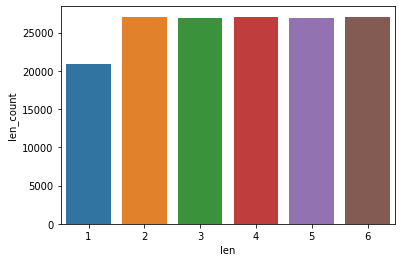

In [56]:
import seaborn as sns
sns.barplot(data=df_len_count, x='len', y='len_count')

## Get Vocabulary

In [58]:
# 학습 데이터로부터 단어 사전(Vocabulary) 구축
train_gt = [gt for gt in train['label']]
train_gt = "".join(train_gt)
letters = sorted(list(set(list(train_gt))))
print(len(letters))

2349


In [59]:
vocabulary = ["-"] + letters
print(len(vocabulary))
idx2char = {k:v for k,v in enumerate(vocabulary, start=0)}
char2idx = {v:k for k,v in idx2char.items()}

2350


## CustomDataset

In [60]:
class CustomDataset(Dataset):
    def __init__(self, img_path_list, label_list, train_mode=True):
        self.img_path_list = img_path_list
        self.label_list = label_list
        self.train_mode = train_mode
        
    def __len__(self):
        return len(self.img_path_list)
    
    def __getitem__(self, index):
        image = Image.open(self.img_path_list[index]).convert('RGB')
        
        if self.train_mode:
            image = self.train_transform(image)
        else:
            image = self.test_transform(image)
            
        if self.label_list is not None:
            text = self.label_list[index]
            return image, text
        else:
            return image
    
    # Image Augmentation
    def train_transform(self, image):
        transform_ops = transforms.Compose([
            transforms.Resize((CFG['IMG_HEIGHT_SIZE'],CFG['IMG_WIDTH_SIZE'])),
            transforms.ToTensor(),
            #transforms.RandomResizedCrop((CFG['IMG_HEIGHT_SIZE'], CFG['IMG_WIDTH_SIZE'])),
            transforms.ColorJitter(),
            transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
        ])
        return transform_ops(image)
    
    def val_transform(self, image):
        transform_ops = transforms.Compose([
            transforms.Resize((CFG['IMG_HEIGHT_SIZE'],CFG['IMG_WIDTH_SIZE'])),
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
        ])
        return transform_ops(image)
    
    def test_transform(self, image):
        transform_ops = transforms.Compose([
            transforms.Resize((CFG['IMG_HEIGHT_SIZE'],CFG['IMG_WIDTH_SIZE'])),
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
        ])
        return transform_ops(image)

In [61]:
train_dataset = CustomDataset(train['img_path'].values, train['label'].values, True)
train_loader = DataLoader(train_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=True)

val_dataset = CustomDataset(val['img_path'].values, val['label'].values, False)
val_loader = DataLoader(val_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=True)

In [62]:
image_batch, text_batch = iter(train_loader).next()
print(image_batch.size(), text_batch)

torch.Size([256, 3, 150, 332]) ('부엌깨다', '설렁탕연합', '건축', '앞서', '관련', '사상밀리미터', '싸우다공', '터미널인터넷', '차', '범인끼어들다', '인선언하다', '보이다', '해배추', '사월무덤', '쇳', '낱다르다', '헬', '종류확신하다', '각자마디', '씻기다률', '기본', '튀기다', '사랑하다요청', '패', '운동복작품', '귀엽다뭐', '내일넘어오다', '멸치', '벌떡신사', '장점연구원', '제외하다관리', '쓰레기탓', '이래서', '운영하다남자', '똑크리스마스', '어째서강조', '한', '열보조', '단골단체', '손해승리하다', '져', '느끼다', '동부였', '경쟁력극히', '자랑스럽다', '많아지다쏘다', '와', '치다뜹', '밥맛있다', '한복', '부서지다', '논의하다', '어떻다출신', '출입국', '깊이', '대규모치다', '간격밝혀지다', '토요일협', '왈공간', '뽀', '유리하다네', '기울다', '수학', '태우다몄', '안전', '여', '국립출입', '연구하다찬성', '대상자룩', '씨세기', '주의하다쿠', '병실깡패', '한', '하', '지리산볼링', '강력하다', '전문갖다', '대답하다잠', '왼손', '장례식', '각각탁월하다', '인원돌리다', '쓰다시스템', '자격증테스트', '상징적인하', '집안', '밈', '생명호', '보도절망', '게다가', '슬그머니', '처지텀', '병실일본어', '당', '발바닥금연', '오페라', '경쟁보고', '새우다싸다', '밤새우다사실', '애아픔', '올라가다', '필연적강아지', '일등표', '여섯그림', '지워지다', '뭣그해', '전망하다꽃잎', '결승', '초점원', '천만지다', '사랑하다해물', '그', '휼', '야채', '뭐이름', '찾다토론자', '과', '한국적이때', '씨', '높아무리', '많아지다톡', '덜', '구월뺐', '부러워하다깎', '짙다색연필', '켭왼쪽', '

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


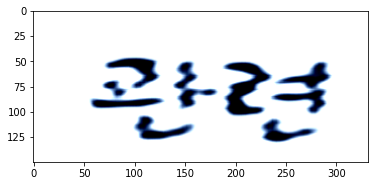

In [87]:
img = image_batch[4]
img = img.cpu().numpy().T
img = np.swapaxes(img, 0, 1)
plt.imshow(img)
plt.

In [20]:
image_batch, text_batch = iter(val_loader).next()
print(image_batch.size(), text_batch)

torch.Size([128, 3, 150, 332]) ('실내계속되다', '저러다한국적', '영역천', '팔월죕', '주다', '떡환영', '냉장고', '사귀다', '교환하다', '경계인류', '긴장콥', '허락', '오락', '캐나다러시아', '조사하다', '탰행사', '유월녕', '지난날최소', '지속적느낌', '대화하다', '소유자결', '시각그래픽', '차림', '전철여기저기', '자살', '햇살', '씩씩하다씨앗', '위쪽선명하다', '젓다', '어머', '주름살적다', '돌리다세금', '인삼차엊그제', '점심시간과외', '닭고기이미', '전달하다총', '대중교통풋', '쓴맛추가되다', '졸다식욕', '딱딱하다짹', '맛친구', '스포츠똑바로', '엔신혼여행', '떤갈등', '엔인정되다', '엿보다적응', '조용하다', '상대속', '준비되다', '옇승객', '맡다엄격하다', '답답하다생선', '정말', '한반도신', '약국', '따뜻하다군', '팩시밀리냇물', '찬성하다년도', '분량척', '훽게으르다', '제자인사', '섟메뉴', '적다탸', '능동적브랜드', '야채있다', '여행사', '강수량서서히', '틘외출', '신화껼', '불가능하다악', '외롭다이민', '조용하다공짜', '전문직지점', '상징하다정보', '그이', '순수', '수업시도하다', '대표적가능성', '그분소화하다', '걱정하다립', '계산자판기', '더위', '노력하다이성', '운전기사', '마련', '피하다등록금', '가만히체육', '모임', '운중학생', '제발', '때리다', '중단켠', '촬영', '나들이월요일', '폰동대문시장', '이웃세계적', '만큼', '지도자공연히', '침착하다', '캄캄하다운', '갈증', '못생기다씨', '소풍', '꾸준하다활용', '외로움', '염려', '개정신', '단순하다', '모범주문', '연기', '주다', '아드님게다가', '큰절', '위협졔', '옛날이야기짐', '배우자대낮', '사건대비', '성공그리하여', '바이올린만두', 

## Denoising

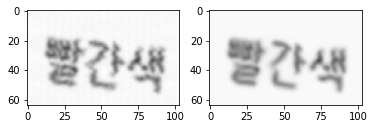

In [21]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
img = cv2.imread("train/TRAIN_00000.png", cv2.IMREAD_COLOR)
dst = cv2.fastNlMeansDenoisingColored(img,None,10,10,7,21)
plt.subplot(121),plt.imshow(img)
plt.subplot(122),plt.imshow(dst)
plt.show()

## Model Define

In [22]:
class RecognitionModel(nn.Module):
    def __init__(self, num_chars=len(char2idx), rnn_hidden_size=256):
        super(RecognitionModel, self).__init__()
        self.num_chars = num_chars
        self.rnn_hidden_size = rnn_hidden_size

        resnet = resnet152(pretrained=True)
        resnet_modules = list(resnet.children())[:-3]
        self.feature_extract = nn.Sequential(
            *resnet_modules,
            nn.Conv2d(1024, 1024, kernel_size=(3,6), stride=1, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True)
        )

        self.linear1 = nn.Linear(10240, rnn_hidden_size)
        
        # RNN
        self.rnn = nn.RNN(input_size=rnn_hidden_size, 
                            hidden_size=rnn_hidden_size,
                            bidirectional=True, 
                            batch_first=True)
        self.linear2 = nn.Linear(self.rnn_hidden_size*2, num_chars)
        
        
    def forward(self, x):
        # CNN
        x = self.feature_extract(x) # [batch_size, channels, height, width]
        x = x.permute(0, 3, 1, 2) # [batch_size, width, channels, height]
         
        batch_size = x.size(0)
        T = x.size(1)
        x = x.view(batch_size, T, -1) # [batch_size, T==width, num_features==channels*height]
        x = self.linear1(x)
        
        # RNN
        x, hidden = self.rnn(x)
        
        output = self.linear2(x)
        output = output.permute(1, 0, 2) # [T==10, batch_size, num_classes==num_features]
        
        return output

## Define CTC Loss

In [23]:
criterion = nn.CTCLoss(blank=0) # idx 0 : '-'

In [24]:
def encode_text_batch(text_batch):
    text_batch_targets_lens = [len(text) for text in text_batch]
    text_batch_targets_lens = torch.IntTensor(text_batch_targets_lens)
    
    text_batch_concat = "".join(text_batch)
    text_batch_targets = [char2idx[c] for c in text_batch_concat]
    text_batch_targets = torch.IntTensor(text_batch_targets)
    
    return text_batch_targets, text_batch_targets_lens

In [25]:
def compute_loss(text_batch, text_batch_logits):
    """
    text_batch: list of strings of length equal to batch size
    text_batch_logits: Tensor of size([T, batch_size, num_classes])
    """
    text_batch_logps = F.log_softmax(text_batch_logits, 2) # [T, batch_size, num_classes]  
    text_batch_logps_lens = torch.full(size=(text_batch_logps.size(1),), 
                                       fill_value=text_batch_logps.size(0), 
                                       dtype=torch.int32).to(device) # [batch_size] 

    text_batch_targets, text_batch_targets_lens = encode_text_batch(text_batch)
    loss = criterion(text_batch_logps, text_batch_targets, text_batch_logps_lens, text_batch_targets_lens)

    return loss

In [26]:
def remove_duplicates(text):
    if len(text) > 1:
        letters = [text[0]] + [letter for idx, letter in enumerate(text[1:], start=1) if text[idx] != text[idx-1]]
    elif len(text) == 1:
        letters = [text[0]]
    else:
        return ""
    return "".join(letters)

def correct_prediction(word):
    parts = word.split("-")
    parts = [remove_duplicates(part) for part in parts]
    corrected_word = "".join(parts)
    return corrected_word

In [27]:
def compute_acc(text_batch, text_batch_logits):
    text_batch_tokens = F.softmax(text_batch_logits, 2).argmax(2) # [T, batch_size]
    text_batch_tokens = text_batch_tokens.T # [batch_size, T]

    check = []; cnt = 0
    for text_tokens, answer in zip(text_batch_tokens, text_batch):
        text = [idx2char[int(idx)] for idx in text_tokens]
        text = "".join(text)
        
        check.append(1 if correct_prediction(text) == answer else 0)
            
    return check


## Training Recode

In [28]:
from datetime import datetime
current_epoch = 1
recode_df = pd.DataFrame(columns=['epoch', 'train_loss', 'val_loss',
                                 'train_acc', 'val_acc', 'best_loss',
                                  'best_acc'])
dir_name = datetime.now().strftime("%Y%m%d_%H%M%S")
fig, axes = plt.subplots(1, 2)
plt.close(fig)

In [29]:
def Recode(epoch, model, train_loss, val_loss, train_acc, val_acc, best_loss, best_acc, model_save=False):
    global recode_df, fig, axes
    
    # Data Write
    os.makedirs(f"./result/{dir_name}", exist_ok=True)
    new_data = {
        "epoch" : epoch,
        "train_loss" : train_loss,
        "val_loss" : val_loss,
        "train_acc" : train_acc,
        "val_acc" : val_acc,
        "best_loss" : best_loss,
        "best_acc" : best_acc
    }
    
    recode_df = recode_df.append(new_data,  ignore_index=True)
    recode_df.to_csv(f'./result/{dir_name}/recode.csv', index=False)
    
    
    # Data Visualization 
    os.makedirs(f"./result/{dir_name}/plot", exist_ok=True)
    fig, axes = plt.subplots(1, 2)
    fig = plt.figure(figsize=(20, 7))

    ax1 = fig.add_subplot(1, 2, 1)
    ax1.plot(recode_df['train_loss'].to_list(), label="train loss")
    ax1.plot(recode_df['val_loss'].to_list(), label="val loss")
    ax1.legend()

    ax2 = fig.add_subplot(1, 2, 2)
    ax2.plot(recode_df['train_acc'], label="train Accuracy")
    ax2.plot(recode_df['val_acc'], label="val Accuracy")
    ax2.legend()
    #plt.close(fig)
    #plt.ioff()
    
    if os.path.isfile(f"./result/{dir_name}/plot/loss_and_acc.png"):
        os.remove(f"./result/{dir_name}/plot/loss_and_acc.png")
    plt.savefig(f"./result/{dir_name}/plot/loss_and_acc.png")
    
    # Write Hyperparameter
    if epoch == 1:
        with open(f"./result/{dir_name}/train.txt",'w',encoding='UTF-8') as f:
            for key, values in CFG.items():
                f.write(f"{key} {values}" + "\n")
         
    if model_save:
        torch.save(model, f"./result/{dir_name}/model.pt")
    
    

## Train

In [30]:
def train(model, optimizer, train_loader, val_loader, scheduler, device):
    global current_epoch
    model.to(device)
    
    best_model = None
    early_stop = 5
    
    if current_epoch != 1:
        tmp = pd.read_csv(f'./result/{dir_name}/recode.csv')
        best_acc = tmp['best_loss'][current_epoch-2]
        best_loss = tmp['best_acc'][current_epoch-2]
        if os.path.isfile(f"./result/{dir_name}/model.pt"):
            model = torch.load(f"./result/{dir_name}/model.pt", map_location= device)
    else:
        best_acc = -1
        best_loss = 1e9
        
        
    for epoch in range(current_epoch, current_epoch + CFG['EPOCHS']+1):
        model.train()
        train_loss = []
        train_acc = []
        model_save = False
        for image_batch, text_batch in tqdm(iter(train_loader)):
            image_batch = image_batch.to(device)
            
            optimizer.zero_grad()
            
            with torch.cuda.amp.autocast():
                text_batch_logits = model(image_batch)
                loss = compute_loss(text_batch, text_batch_logits)
            
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            
            train_acc += compute_acc(text_batch, text_batch_logits)
            train_loss.append(loss.item())
        
        _train_loss = np.mean(train_loss)
        
        
        _train_acc = 100. * sum(train_acc) / len(train_loader.dataset)
        _val_loss, _val_acc = validation(model, val_loader, device)
        
        print(f'Epoch : [{epoch}] Train CTC Loss : [{_train_loss:.5f}] Val CTC Loss : [{_val_loss:.5f}]')
        print(f'Epoch : [{epoch}] Train Accuracy : [{_train_acc:.5f}] Val Accuracy : [{_val_acc:.5f}]')
        
        if scheduler is not None:
            scheduler.step(_val_loss)
        
        if best_loss > _val_loss or best_acc < _val_acc:
            early_stop += 1
        
        if best_loss > _val_loss:
            best_loss = _val_loss
            
        if best_acc < _val_acc:
            best_acc = _val_acc
            best_model = model
            model_save = True
            
        early_stop -= 1
        current_epoch += 1
        Recode(epoch, model, _train_loss, _val_loss, _train_acc, _val_acc, best_loss, best_acc, model_save)
        
        if early_stop == 0:
            break
    
    return best_model

## Validation

In [31]:
def validation(model, val_loader, device):
    model.eval()
    val_loss = []; val_acc = []
    with torch.no_grad():
        for image_batch, text_batch in tqdm(iter(val_loader)):
            image_batch = image_batch.to(device)
            
            with torch.cuda.amp.autocast():
                text_batch_logits = model(image_batch)
                loss = compute_loss(text_batch, text_batch_logits)
            
            val_loss.append(loss.item())
            val_acc += compute_acc(text_batch, text_batch_logits)
    
    _val_loss = np.mean(val_loss)
    _val_acc = 100. * sum(val_acc) / len(val_loader.dataset)
    return _val_loss, _val_acc

## Run!!

In [32]:
model = RecognitionModel()
model.eval()
scaler = torch.cuda.amp.GradScaler()
optimizer = torch.optim.AdamW(params = model.parameters(), lr = CFG["LEARNING_RATE"], weight_decay=0.3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2,threshold_mode='abs',min_lr=1e-8, verbose=True)

In [33]:
from torchsummary import summary
summary(model, input_size=(3, CFG['IMG_HEIGHT_SIZE'], CFG['IMG_WIDTH_SIZE']), batch_size=CFG['BATCH_SIZE'], device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [128, 64, 75, 166]           9,408
       BatchNorm2d-2         [128, 64, 75, 166]             128
              ReLU-3         [128, 64, 75, 166]               0
         MaxPool2d-4          [128, 64, 38, 83]               0
            Conv2d-5          [128, 64, 38, 83]           4,096
       BatchNorm2d-6          [128, 64, 38, 83]             128
              ReLU-7          [128, 64, 38, 83]               0
            Conv2d-8          [128, 64, 38, 83]          36,864
       BatchNorm2d-9          [128, 64, 38, 83]             128
             ReLU-10          [128, 64, 38, 83]               0
           Conv2d-11         [128, 256, 38, 83]          16,384
      BatchNorm2d-12         [128, 256, 38, 83]             512
           Conv2d-13         [128, 256, 38, 83]          16,384
      BatchNorm2d-14         [128, 256,

  0%|          | 0/1206 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

Epoch : [15] Train CTC Loss : [0.09240] Val CTC Loss : [0.07729]
Epoch : [15] Train Accuracy : [95.69166] Val Accuracy : [94.16246]


  0%|          | 0/1206 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

Epoch : [16] Train CTC Loss : [0.09251] Val CTC Loss : [0.07603]
Epoch : [16] Train Accuracy : [95.68323] Val Accuracy : [94.21394]


  0%|          | 0/1206 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

Epoch : [17] Train CTC Loss : [0.09235] Val CTC Loss : [0.07696]
Epoch : [17] Train Accuracy : [95.69295] Val Accuracy : [94.18820]


  0%|          | 0/1206 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

Epoch : [18] Train CTC Loss : [0.09270] Val CTC Loss : [0.07594]
Epoch : [18] Train Accuracy : [95.64693] Val Accuracy : [94.29116]


  0%|          | 0/1206 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

Epoch : [19] Train CTC Loss : [0.09229] Val CTC Loss : [0.07605]
Epoch : [19] Train Accuracy : [95.70138] Val Accuracy : [94.20364]
Epoch 00019: reducing learning rate of group 0 to 1.5000e-04.


  0%|          | 0/1206 [00:00<?, ?it/s]


KeyboardInterrupt



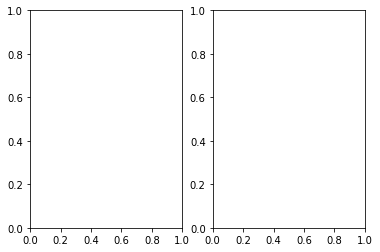

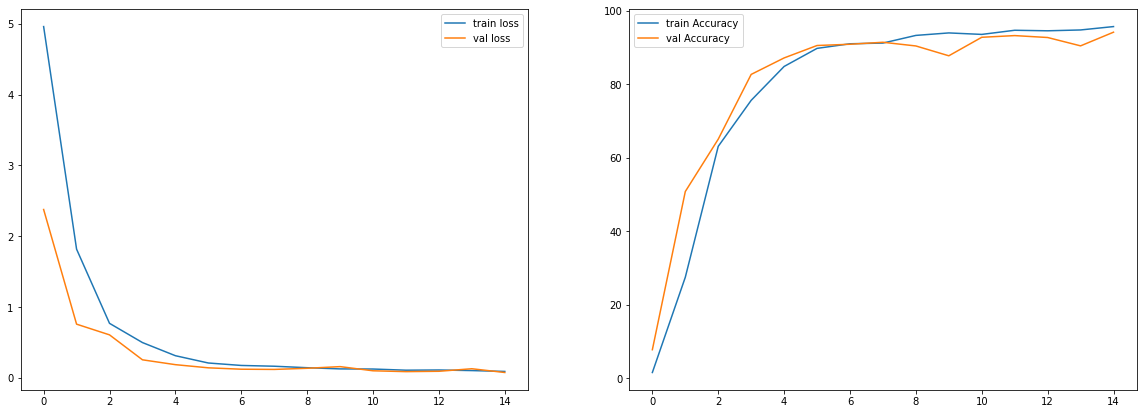

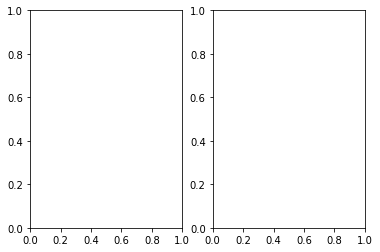

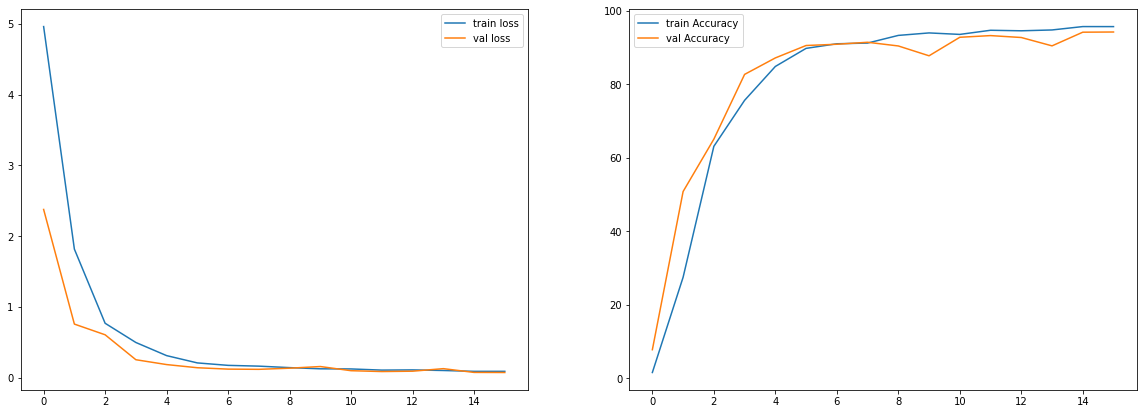

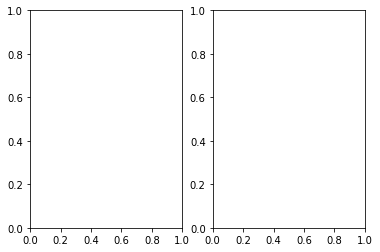

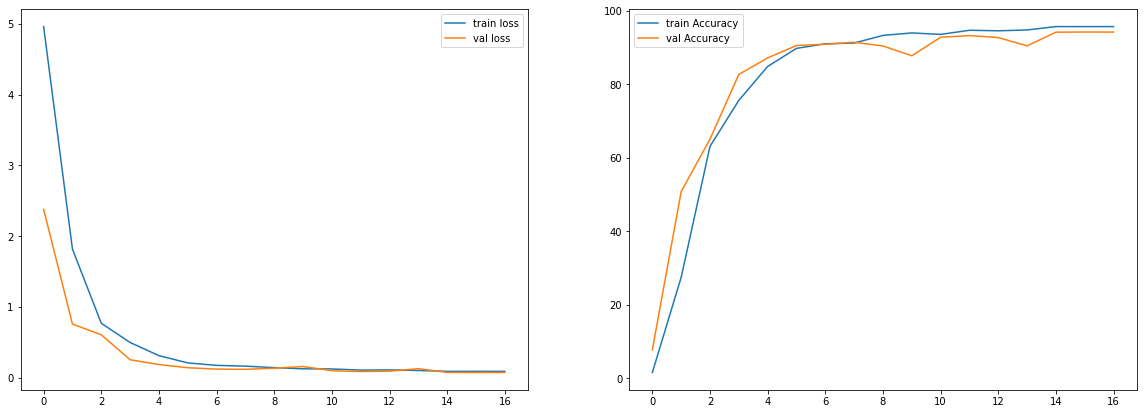

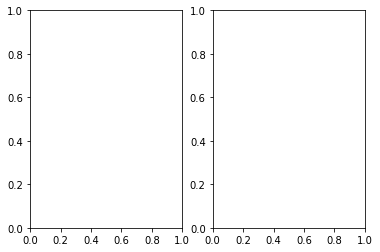

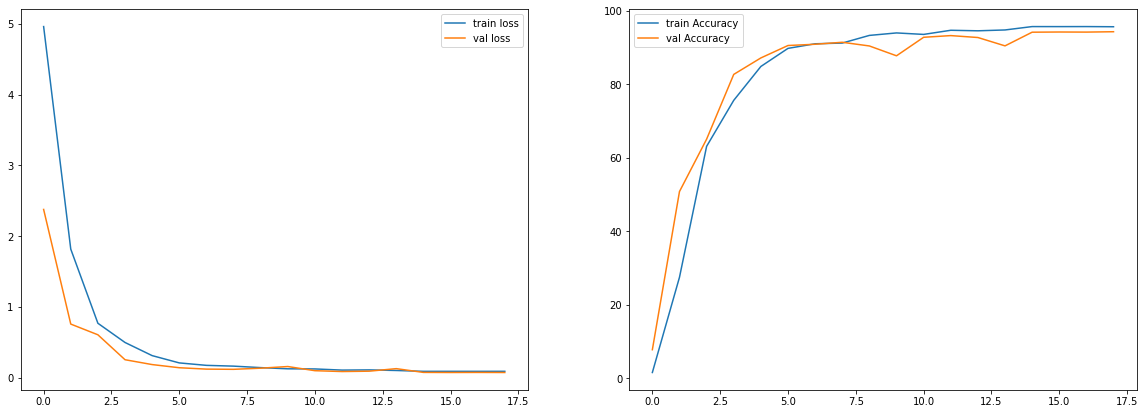

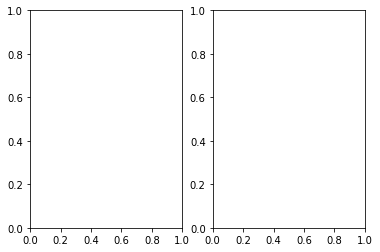

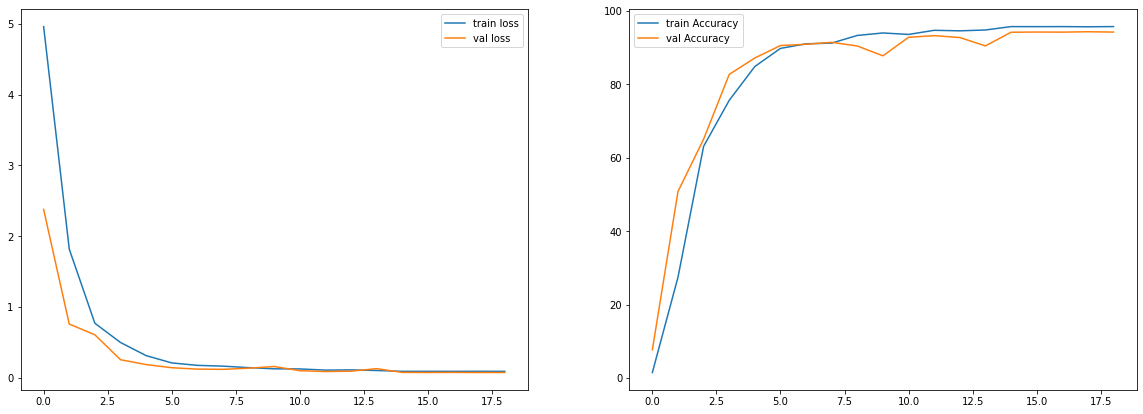

In [42]:
infer_model = train(model, optimizer, train_loader, val_loader, scheduler, device)

In [59]:
model = torch.load(f"./result/{dir_name}/model.pt", map_location= device)

## Inference

In [60]:
test = pd.read_csv('./test.csv')

In [61]:
test_dataset = CustomDataset(test['img_path'].values, None)
test_loader = DataLoader(test_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False)

In [62]:
def decode_predictions(text_batch_logits):
    text_batch_tokens = F.softmax(text_batch_logits, 2).argmax(2) # [T, batch_size]
    text_batch_tokens = text_batch_tokens.numpy().T # [batch_size, T]

    text_batch_tokens_new = []
    for text_tokens in text_batch_tokens:
        text = [idx2char[idx] for idx in text_tokens]
        text = "".join(text)
        text_batch_tokens_new.append(text)

    return text_batch_tokens_new

def inference(model, test_loader, device):
    model.eval()
    preds = []
    with torch.no_grad():
        for image_batch in tqdm(iter(test_loader)):
            image_batch = image_batch.to(device)
            
            text_batch_logits = model(image_batch)
            
            text_batch_pred = decode_predictions(text_batch_logits.cpu())
            
            preds.extend(text_batch_pred)
    return preds

In [63]:
predictions = inference(model, test_loader, device)

  0%|          | 0/580 [00:00<?, ?it/s]

## Submission

In [68]:
# 샘플 별 추론결과를 독립적으로 후처리
def remove_duplicates(text):
    if len(text) > 1:
        letters = [text[0]] + [letter for idx, letter in enumerate(text[1:], start=1) if text[idx] != text[idx-1]]
    elif len(text) == 1:
        letters = [text[0]]
    else:
        return ""
    return "".join(letters)

def correct_prediction(word):
    parts = word.split("-")
    parts = [remove_duplicates(part) for part in parts]
    corrected_word = "".join(parts)
    return corrected_word

In [69]:
submit = pd.read_csv('./sample_submission.csv')
submit['label'] = predictions
submit['label'] = submit['label'].apply(correct_prediction)

In [70]:
submit.to_csv('./submission4.csv', index=False)

In [71]:
predictions

['-날-------말--------',
 '-상-------황--------',
 '-받-아---들---이--다---',
 '-바------구----늬----',
 '-살----------------',
 '-빼----놓-----다-----',
 '-인---식---하---다----',
 '-센------터---------',
 '-소------풍---------',
 '-광--------주-------',
 '-나-------낙--------',
 '-위-------험--------',
 '-도-------도--------',
 '-술------표---------',
 '-괴-로-워----하---다---',
 '-카-------드--------',
 '-합-----치치--다다-----',
 '-다---정--하하--다다----',
 '-톤-------자자-------',
 '-가--능----하----다---',
 '-호-------주--------',
 '-발---전---되---다----',
 '-피----우----다------',
 '-스----웨-----터-----',
 '-시---작---되---다----',
 '-겨-------울--------',
 '-예--------선-------',
 '-한----국-----말-----',
 '-세---워---지---다----',
 '-비----방----밥------',
 '-좋------다다--------',
 '-남-대---문---시---장--',
 '-보---수------적-----',
 '-사----진-----기-----',
 '-내---리-----다다-----',
 '-핑------핑---------',
 '-맛---없----다다------',
 '-특----별-----히-----',
 '-우-------선선-------',
 '-대-----답답---------',
 '-학--------생-------',
 '-여------덟---------',
 '-본-------질--------',
 '-현-------

In [39]:
import pandas as pd

df = pd.read_csv('train.csv')
df.head()

,id,img_path,label
0,TRAIN_00000,./train/TRAIN_00000.png,빨간색
1,TRAIN_00001,./train/TRAIN_00001.png,머
2,TRAIN_00002,./train/TRAIN_00002.png,차차
3,TRAIN_00003,./train/TRAIN_00003.png,써
4,TRAIN_00004,./train/TRAIN_00004.png,놓치다
